In [126]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle

In [127]:
wandb.login()
config = {"subj":subj, "model":"encoding text"}
wandb.init(project="brain_tuning",config=config )

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Baseline Top-1 Accuracy,▁
Baseline Top-5 Accuracy,▁
Identification Accuracy,▁
Top-1 Accuracy,▁
Top-1 Accuracy over Baseline,▁
Top-5 Accuracy,▁
Top-5 Accuracy over Baseline,▁
Baseline Top-1 Accuracy,0.12674
Baseline Top-5 Accuracy,0.63371
Identification Accuracy,0.86783
Top-1 Accuracy,2.15463


In [128]:
# Define the base path where the BOLD5000 data is stored
base_path = "/home/matteo/data/BOLD5000"

# Define the path to the stimuli data
stimuli_path = opj(base_path, "stimuli", "BOLD5000_Stimuli")

# Define the subject identifier
subj = "CSI4"

# Get all .nii.gz files in the base path
data_path = glob.glob(opj(base_path, "*.nii.gz"))

# Filter the data_path list to include only files related to the specified subject
data_path = [x for x in data_path if subj in x]

# Further filter the data_path list to include only files that contain "TYPED" in their name
data_path = [x for x in data_path if "TYPED" in x]

target_dir = f"/home/matteo/storage/brain_tuning/{subj}"
os.makedirs(target_dir,exist_ok=True)


config = {"subj":subj, "model":"encoding"}
# wandb.init(project="brain_tuning",config=config )

In [129]:
# import os
# os.listdir(target_dir)

In [130]:
## Load the full brain data
train_fmri = np.load(opj(target_dir, "fmri_train.npy"))
val_fmri = np.load(opj(target_dir, "fmri_val.npy"))
test_fmri = np.load(opj(target_dir, "fmri_test.npy"))

## load captions dat
train_captions = np.load(opj(target_dir, "train_captions.npy"))
val_captions = np.load(opj(target_dir, "val_captions.npy"))
test_captions = np.load(opj(target_dir, "test_captions.npy"))


## Extract text features

In [131]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import tqdm

# Load the CLIP text model and tokenizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
text_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

text_model.to(device)
text_model.eval()

## Extract text features using CLIP in batches
def extract_text_features(texts, text_model, text_tokenizer, device, batch_size=32):
    text_features = []
    with torch.no_grad():
        for i in tqdm.trange(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Tokenize and process the text batch
            inputs = text_tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = text_model(**inputs).pooler_output  # Get the pooled output for the text features
            
            text_features.append(outputs)

        # Concatenate all features along the batch dimension
        text_features = torch.cat(text_features, dim=0)

    return text_features


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.mlp.fc1.weight', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.layer_norm2.weight', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.layer_norm2.weight', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.8.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.weight', 'vision_model.encoder.layers.11.l

In [132]:
train_text_features = extract_text_features(train_captions.tolist(), text_model, text_tokenizer, device)
val_text_features = extract_text_features(val_captions.tolist(), text_model, text_tokenizer, device)
test_text_features = extract_text_features(test_captions.tolist(), text_model, text_tokenizer, device)

100%|██████████| 15/15 [00:00<00:00, 28.88it/s]


In [133]:
## Check feature shapes
print("Training text features shape:", train_text_features.shape)
print("Validation text features shape:", val_text_features.shape)
print("Testing text features shape:", test_text_features.shape)


Training text features shape: torch.Size([2244, 512])
Validation text features shape: torch.Size([397, 512])
Testing text features shape: torch.Size([467, 512])


In [134]:
## Save the image features
np.save(opj(target_dir, "train_text_features.npy"), train_text_features.cpu().numpy())
np.save(opj(target_dir, "val_text_features.npy"), val_text_features.cpu().numpy())
np.save(opj(target_dir, "test_text_features.npy"), test_text_features.cpu().numpy())


## Standardize the data

In [135]:
from himalaya.ridge import RidgeCV
from himalaya.backend import set_backend


device_id = 6 
torch.cuda.set_device(device_id)  # Set the current device

backend = set_backend("torch_cuda")

train_text_features_device = backend.asarray(train_text_features).to(f'cuda:{device_id}')
train_fmri_device = backend.asarray(train_fmri).to(f'cuda:{device_id}')


encoding_model = RidgeCV(alphas=[1,10,100,1e3,1e4])
encoding_model.fit(train_text_features_device, train_fmri_device)


RidgeCV(alphas=[1, 10, 100, 1000.0, 10000.0])

In [136]:
val_predictions = encoding_model.predict(backend.asarray(val_text_features.cpu()).to(f'cuda:{device_id}'))


In [137]:

## Compute the correlation between the predicted and actual fMRI responses

voxel_correlations = np.zeros(val_predictions.shape[1])
for i in tqdm.trange(val_predictions.shape[1]):
    voxel_correlations[i] = np.corrcoef(val_predictions[:, i], val_fmri[:, i])[0, 1]

100%|██████████| 191478/191478 [00:24<00:00, 7822.89it/s]


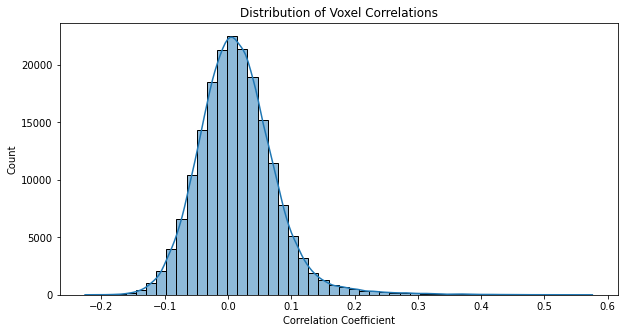

In [138]:
## Show the distribution of voxel correlations in a fig and log it to wandb as an image

fig = plt.figure(figsize=(10, 5))
sns.histplot(voxel_correlations, bins=50, kde=True)
plt.title("Distribution of Voxel Correlations")
plt.xlabel("Correlation Coefficient")

wandb.log({"Voxel Correlations": wandb.Image(fig)})
plt.show()








In [139]:
top_N= 10000
top_voxels = np.argsort(voxel_correlations)[::-1][:top_N]

top_voxel_correlations = voxel_correlations[top_voxels]

#print min of max correlation of top voxels
print("Minimum of maximum correlation of top voxels:", np.min(top_voxel_correlations))
print("Maximum of maximum correlation of top voxels:", np.max(top_voxel_correlations))

Minimum of maximum correlation of top voxels: 0.11183034351484682
Maximum of maximum correlation of top voxels: 0.5755585077976798


In [140]:
## Select the top fMRI voxels based on the correlation with the predicted responses

train_fmri_top = train_fmri[:, top_voxels]
val_fmri_top = val_fmri[:, top_voxels]
test_fmri_top = test_fmri[:, top_voxels]



In [141]:
import pickle

# Load the masker object from the pickle file
with open(f'{target_dir}/masker_object.pkl', 'rb') as f:
    masker = pickle.load(f)

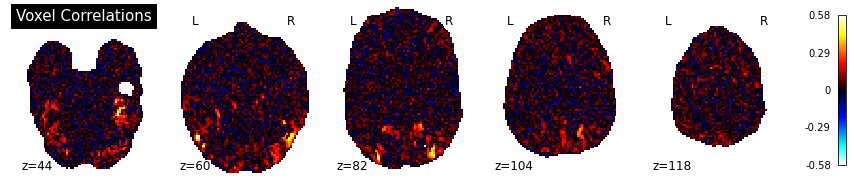

In [142]:
#load masker


# ## Plot a map of the voxel correlations
voxel_correlation_map = masker.inverse_transform(voxel_correlations) ##Possibly to do
# Specify the colormap
cmap = "cold_hot"  # or any colormap you prefer

# Create a figure and capture the plot in it
# Save the plot as an image file
output_path = f"{target_dir}/text_voxel_correlation_map.png"
plot_stat_map(voxel_correlation_map, bg_img=None, title="Voxel Correlations",
              display_mode="z", cut_coords=5, colorbar=True, cmap="cold_hot")
plt.savefig(output_path, bbox_inches="tight")  # Save the plot

# Log the saved image to wandb
wandb.log({"Voxel Correlations new": wandb.Image(output_path)})



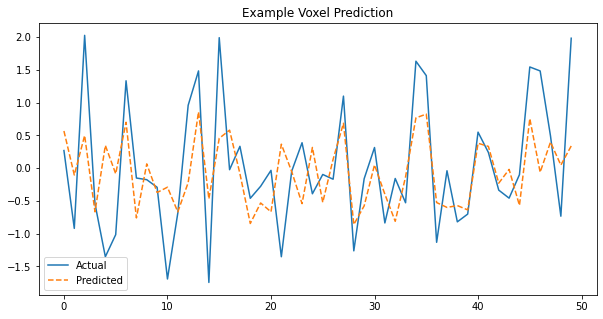

In [143]:
## plot an example of the predicted and actual fMRI responses for a voxel predicted with high accuracy

voxel_idx = top_voxels[0]
fig = plt.figure(figsize=(10, 5))
plt.plot(val_fmri[:50, voxel_idx], label="Actual")
plt.plot(val_predictions[:50, voxel_idx], '--',label="Predicted")
plt.title("Example Voxel Prediction")
plt.legend()

#log the figure to wandb
wandb.log({"Example Voxel Prediction": wandb.Image(fig)})


In [144]:
## Save the top fMRI voxels, voxel correlations and encoding model (ith pickle)
np.save(opj(target_dir, "TEXT_train_fmri_top.npy"), train_fmri_top)
np.save(opj(target_dir, "TEXT_val_fmri_top.npy"), val_fmri_top)
np.save(opj(target_dir, "TEXT_test_fmri_top.npy"), test_fmri_top)

np.save(opj(target_dir, "TEXT_top_voxels.npy"), top_voxels)
np.save(opj(target_dir, "TEXT_top_voxel_correlations.npy"), top_voxel_correlations)

import pickle

with open(opj(target_dir, "TEXT_encoding_model.pkl"), "wb") as f:
    pickle.dump(encoding_model, f)
    



## Perfom a simple baseline with a Ridge brain to image features + kNN to retrieve images

In [145]:
simple_decoding_model = RidgeCV(alphas=[1, 10, 100, 1e3, 1e4])
simple_decoding_model.fit(backend.asarray(train_fmri_top).to(f'cuda:{device_id}'),train_text_features.cpu().to(f'cuda:{device_id}'))

#Use the model to predict test set image features
test_predictions = simple_decoding_model.predict(backend.asarray(test_fmri_top).to(f'cuda:{device_id}'))


/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 2244 < 10000). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


In [146]:
## Use a kNN to retrieve image indices based on the predicted image features

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5)
knn.fit(test_text_features.cpu().numpy())

_, indices = knn.kneighbors(test_predictions, n_neighbors=5)



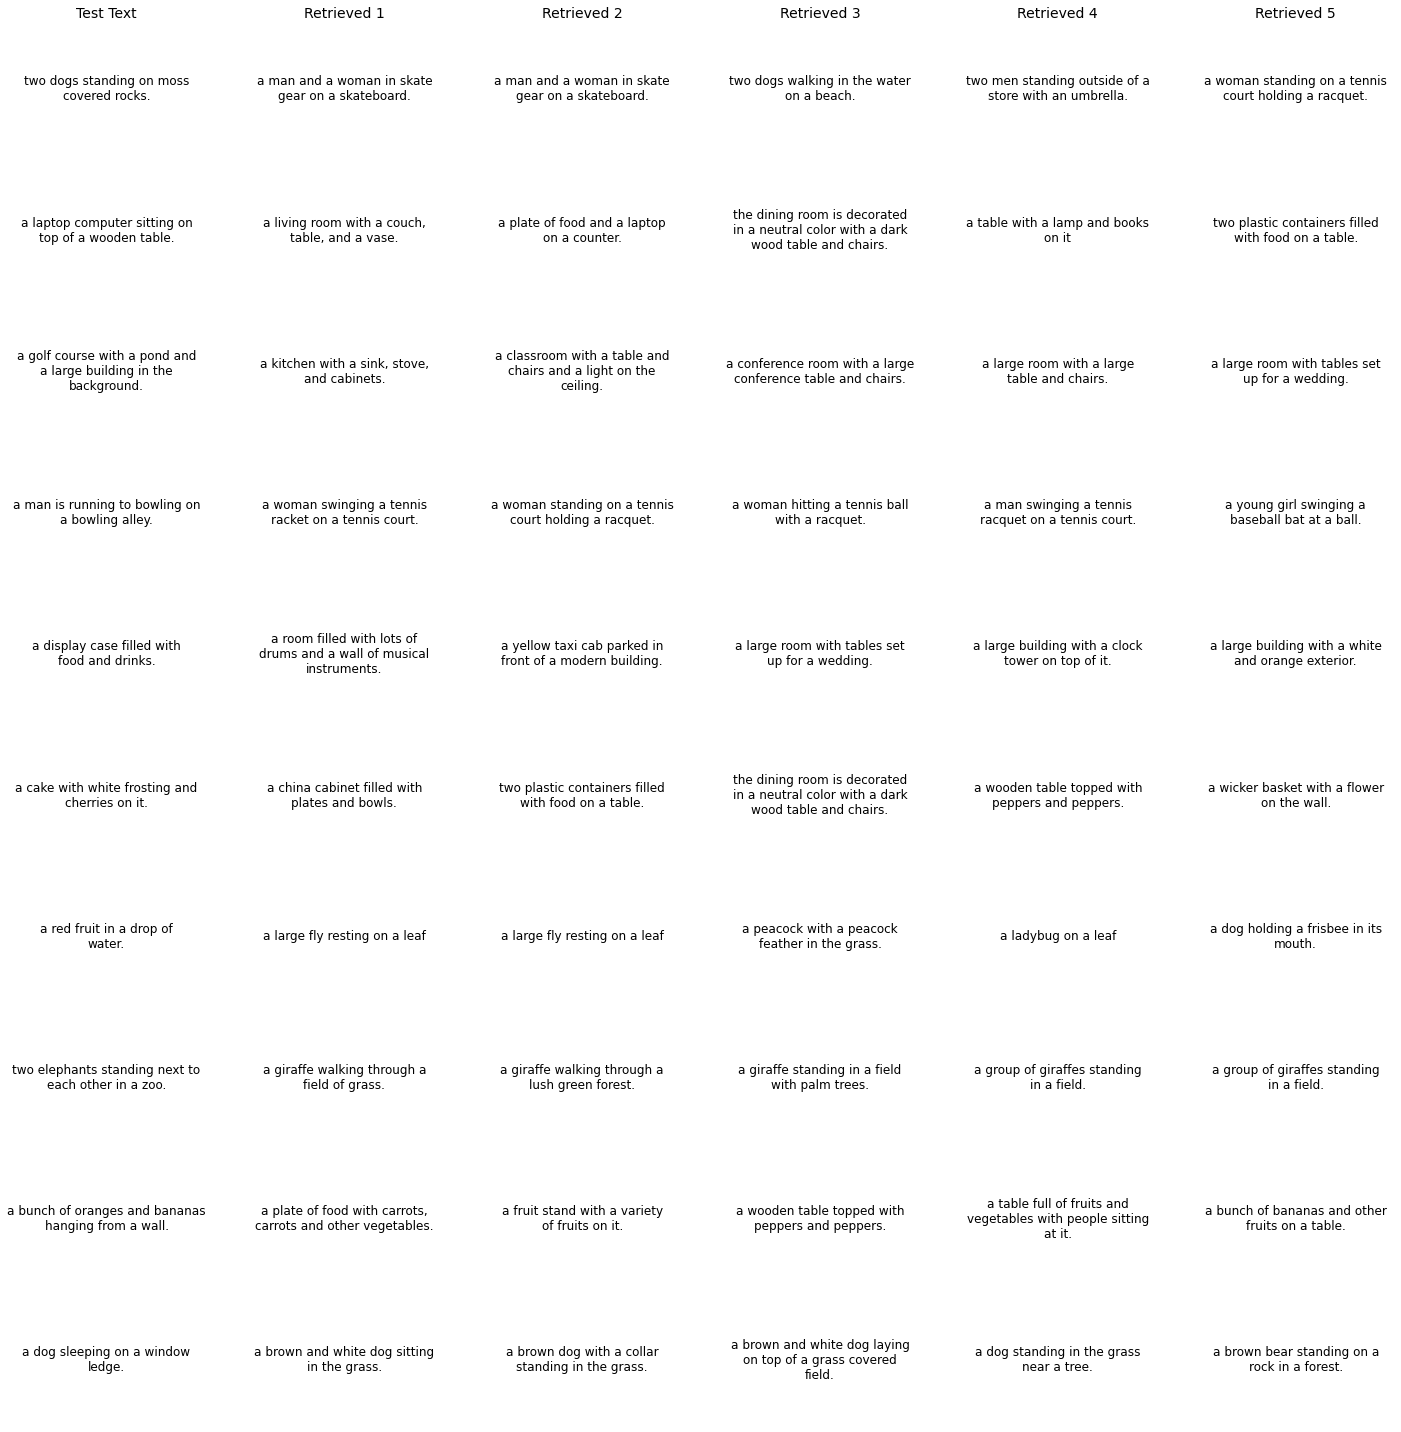

In [147]:
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import wandb
import textwrap

def plot_retrieved_texts(test_texts, retrieved_indices, target_dir, line_width=30):
    """
    Plot the retrieved texts for the first 10 test texts using the provided indices.

    Args:
        test_texts (list): List of test texts.
        retrieved_indices (list of lists): List containing lists of indices of retrieved texts for each test text.
        target_dir (str): Directory to save the figure.
        line_width (int): Maximum number of characters per line.
    """
    plt.figure(figsize=(20, 20))
    for i in range(10):
        # Split test text into multiple lines
        wrapped_test_text = "\n".join(textwrap.wrap(test_texts[i], line_width))
        
        # Plot the test text
        plt.subplot(10, 6, 6 * i + 1)
        plt.text(0.5, 0.5, wrapped_test_text, ha='center', va='center', wrap=True, fontsize=12)
        plt.axis("off")
        if i == 0:
            plt.title("Test Text", fontsize=14)

        # Plot the retrieved texts based on the indices
        for j in range(5):
            retrieved_text = test_texts[retrieved_indices[i][j]]  # Get text using the index
            wrapped_retrieved_text = "\n".join(textwrap.wrap(retrieved_text, line_width))
            
            plt.subplot(10, 6, 6 * i + j + 2)
            plt.text(0.5, 0.5, wrapped_retrieved_text, ha='center', va='center', wrap=True, fontsize=12)
            plt.axis("off")
            if i == 0:
                plt.title(f"Retrieved {j + 1}", fontsize=14)

    plt.tight_layout()

    # Save the figure and log it to wandb
    os.makedirs(opj(target_dir, "figures"), exist_ok=True)
    fig_path = opj(target_dir, "figures", "retrieved_texts.png")
    plt.savefig(fig_path)
    wandb.log({"Retrieved Texts": wandb.Image(fig_path)})

    plt.show()

plot_retrieved_texts(test_captions, indices, target_dir)


In [148]:
## Compute top1 and top5 accuracy

top1_correct = 0
top5_correct = 0


for i in range(len(test_predictions)):
    if i==indices[i][0]:
        top1_correct += 1
    if i in indices[i]:
        top5_correct += 1

top1_accuracy = 100*top1_correct / len(test_predictions)
top5_accuracy = 100*top5_correct / len(test_predictions)

print("Top-1 Accuracy:", top1_accuracy, "%")
print("Top-10 Accuracy:", top5_accuracy, "%")

## compute the baseline accuracy

baseline_top1_accuracy = 100*(1 / len(test_captions))
baseline_top5_accuracy = 100*(5 / len(test_captions))

print()

print("Baseline Top-1 Accuracy:", baseline_top1_accuracy, "%")
print("Baseline Top-5 Accuracy:", baseline_top5_accuracy, "%")
print()

print("Top-1 Accuracy over baseline:", top1_accuracy/baseline_top1_accuracy,)
print("Top-5 Accuracy over baseline:", top5_accuracy/baseline_top5_accuracy,)

## log everything to wandb
wandb.log({"Top-1 Accuracy": top1_accuracy})
wandb.log({"Top-5 Accuracy": top5_accuracy})
wandb.log({"Baseline Top-1 Accuracy": baseline_top1_accuracy})
wandb.log({"Baseline Top-5 Accuracy": baseline_top5_accuracy})
wandb.log({"Top-1 Accuracy over Baseline": top1_accuracy / baseline_top1_accuracy})
wandb.log({"Top-5 Accuracy over Baseline": top5_accuracy / baseline_top5_accuracy})


Top-1 Accuracy: 1.4989293361884368 %
Top-10 Accuracy: 8.565310492505354 %

Baseline Top-1 Accuracy: 0.21413276231263384 %
Baseline Top-5 Accuracy: 1.070663811563169 %

Top-1 Accuracy over baseline: 7.0
Top-5 Accuracy over baseline: 8.000000000000002


In [149]:
## Compute the identification accuracy
def identification_accuracy_fast(P, T):
    n = P.shape[0]
    
    # Compute the mean and standard deviation for each vector in P and T
    P_mean = np.mean(P, axis=1, keepdims=True)
    T_mean = np.mean(T, axis=1, keepdims=True)
    P_std = np.std(P, axis=1, keepdims=True)
    T_std = np.std(T, axis=1, keepdims=True)
    
    # Normalize P and T
    P_normalized = (P - P_mean) / P_std
    T_normalized = (T - T_mean) / T_std
    
    # Compute the correlation matrix using matrix multiplication
    C = np.dot(P_normalized, T_normalized.T) / P.shape[1]

    # Compute identification accuracy per prediction
    id_acc = np.zeros(n)
    for i in tqdm.trange(n):
        id_acc[i] = (C[i, i] >= C[i]).sum()  
        id_acc[i] = id_acc[i] / (n - 1)
    
    # Average identification accuracy
    overall_id_acc = np.mean(id_acc)
    
    return overall_id_acc

In [150]:
id_acc = identification_accuracy_fast(test_predictions.numpy(), test_text_features.cpu().numpy())

print("Identification Accuracy:", id_acc)

#log to wandb

wandb.log({"Identification Accuracy": id_acc})


100%|██████████| 467/467 [00:00<00:00, 67519.47it/s]

Identification Accuracy: 0.8520921598000202


In [151]:
print("All done!", subj)

All done! CSI4
